# Step 0: imports

In [192]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import math, random
from copy import deepcopy

import encode, source, output, additions

from singer import Singer
from note import Note

%matplotlib inline

In [193]:
song = pd.read_csv('music_notes/loch_lomond.csv')
song.columns = [c.strip() for c in song.columns.values]
songnotes = song.loc[:50,['pitch (as sharps)', 'octave']]
llnotes = []
for i in range(songnotes.shape[0]):
    note = songnotes.iloc[i]['pitch (as sharps)']
    octave = int(songnotes.iloc[i]['octave'])
    llnotes.append(Note(note).at_octave(octave))
ll_freq = [n.frequency() for n in llnotes]
# fix initial note repeats
ll_freq = ll_freq[3:]

def get_target(index):
    ''' Takes the index of the current target note
        and returns the target frequency of that note
    '''
    return ll_freq[index]

# Step 1: define our singers
We bundle all of the control and tracking of each voice into an object for easier simulation. We then set up a couple different parameters of singer to build our chorus.

In [202]:
def create_good_singer(duration, adj_per_sec, max_vol):
    return Singer(duration = duration, 
                adj_per_sec = adj_per_sec,
                pid_coeffs=(12,6,.05), max_vol=max_vol,
                starting_freq=random.randint(150,500), control_error_range=(0,0))
def create_flat_singer(duration, adj_per_sec, max_vol):
    return Singer(duration = duration, 
                adj_per_sec = adj_per_sec,
                pid_coeffs=(12,6,.05), max_vol=max_vol,
                starting_freq=random.randint(150,500), control_error_range=(0,0), noise_range=(-2,0))
def create_bad_singer(duration, adj_per_sec, max_vol):
    return Singer(duration = duration, 
                adj_per_sec = adj_per_sec,
                pid_coeffs=(7,6,.05), max_vol=max_vol,
                starting_freq=random.randint(150,500), control_error_range=(0,0))

def get_average_singer(singerlist):
    ttl_vols = sum(np.array([s.volumes for s in singerlist]))
    # hacky fix to avoid dividing by zero
    average = sum(np.array([s.volumes * s.realized for s in singerlist])) / (ttl_vols+0.000001)
    dummy_singer = deepcopy(singerlist[0])
    dummy_singer.volumes = ttl_vols
    dummy_singer.realized = average
    return dummy_singer
        
        

# Step 2: simulation
In this step we see what happens when we unleash our control system on the task of keeping a singer on-pitch with the target

In [219]:
#################
# Parameters
#################
# total number of eigth notes
_notes = len(ll_freq)

# number of control adjustments per second
adj_per_sec = 15

# duration of one eigth note
note_duration = 0.5

num_singers = 10
proportion_good_ear = .1

#################
# setup
#################
# total number of control adjustments
adj_per_note = adj_per_sec * note_duration # should be integer
n = int(_notes * adj_per_note)

# set up singers
singers = []
for i in range(num_singers):
    singers.append(create_flat_singer(n,adj_per_sec, 1/num_singers))

ideal = np.array(ll_freq)
target = np.zeros(n)
flatnesses = np.zeros(n)
flatnesses[0] = 0


#################
# run simulation from t=0 to t=n-1
#################
prev_ideal = ideal[0]
time_since_change = 0
chorus_flatness = flatnesses[0]
num_good_ear = math.floor(num_singers*proportion_good_ear)
for t in range(1,n):
    note_index = math.floor(t/adj_per_note)
    ideal_target = ideal[note_index]
    if ideal_target == prev_ideal:
        time_since_change += 1
    else:
        chorus_flatness = prev_ideal - matching_target
#         print(chorus_flatness)
        prev_ideal = ideal_target
        time_since_change = 0
    prev_notes = [s.get_last_note(t) for s in singers]
    matching_target = sum(prev_notes)/len(prev_notes)
    matching_weight = time_since_change / adj_per_note
#     print(matching_weight)
#     tg = (tg + matching_weight * matching_target)/(1+matching_weight)
    for s in singers[:num_good_ear]:
        s.adjustment((ideal_target + matching_weight * matching_target)/(1+matching_weight))
    for s in singers[num_good_ear:]:
        s.adjustment(((ideal_target - chorus_flatness) + matching_weight * matching_target)/(1+matching_weight))
    
    
    # bookkeeping
    target[t] = ideal[note_index]
    flatnesses[t] = chorus_flatness

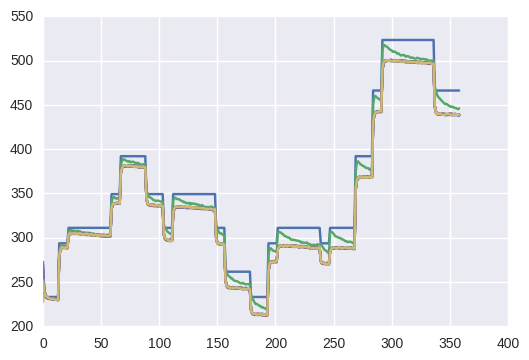

In [220]:
#################
# examine results
#################   
chorus_singer = get_average_singer(singers)
plt.plot(target[1:])
for s in singers:
    plt.plot(s.realized[1:])
# plt.plot(chorus_singer.realized[1:])

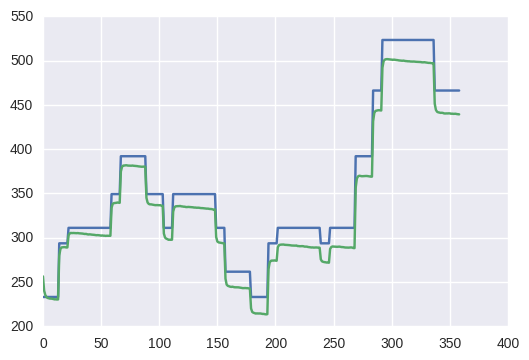

In [221]:
#################
# examine results
#################   
chorus_singer = get_average_singer(singers)
plt.plot(target[1:])
# for s in singers:
#     plt.plot(s.realized[1:])
plt.plot(chorus_singer.realized[1:])

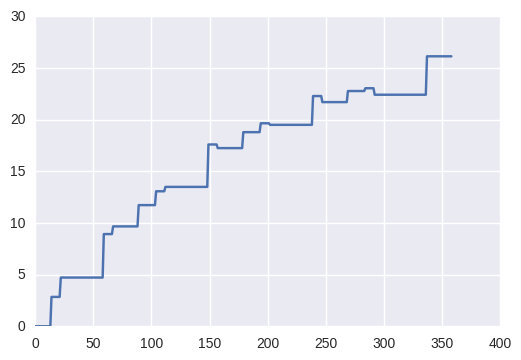

In [222]:
plt.plot(flatnesses[1:])

# Step 6: listen
Rather than just looking at a simple graph of the simulation, we can actually listen to the simulated pitch.

In [199]:
def render_sum(singerlist):
    rendered = [s.render_singing() for s in singerlist]
    return sum(rendered)
def render_average(singerlist):
    chorus_singer = get_average_singer(singers)
    return chorus_singer.render_singing()

In [200]:
# output.play(render_sum(singers))

In [201]:
output.play(render_average(singers))